In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

def get_data_loaders(train_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    temp = torch.tensor(np.random.randint(0, 10, (len(trainset),)))
    trainset.targets = temp.tolist()
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

    return trainloader, testloader

In [5]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)  
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 64 * 4 * 4)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=20):
    model.train()
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        total_train_loss = 0.0
        actual_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            actual_train += (predicted == labels).sum().item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * actual_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0.0
        total_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                total_test_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1, keepdim=True)
                total_correct += preds.eq(labels.view_as(preds)).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(100. * total_correct / len(test_loader.dataset))

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

In [10]:
loss_func = nn.CrossEntropyLoss()

model_1 = CNN_Model()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
train_loader_1, test_loader_1 = get_data_loaders(500, 500)
train_losses_batch_1, test_losses_batch_1, train_accuracies_batch_1, test_accuracies_batch_1 = train_and_evaluate_model(model_1, train_loader_1, test_loader_1, optimizer, loss_func)
batch_params_model_1 = torch.nn.utils.parameters_to_vector(model_1.parameters())

model_2 = CNN_Model()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
train_loader_2, test_loader_2 = get_data_loaders(300, 300)
train_losses_batch_2, test_losses_batch_2, train_accuracies_batch_2, test_accuracies_batch_2 = train_and_evaluate_model(model_2, train_loader_2, test_loader_2, optimizer, loss_func)
batch_params_model_2 = torch.nn.utils.parameters_to_vector(model_2.parameters())

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train Loss: 2.3212, Test Loss: 2.3259
Epoch 2, Train Loss: 2.2964, Test Loss: 2.3225
Epoch 3, Train Loss: 2.2812, Test Loss: 2.3275
Epoch 4, Train Loss: 2.2561, Test Loss: 2.3461
Epoch 5, Train Loss: 2.2131, Test Loss: 2.3888
Epoch 6, Train Loss: 2.1463, Test Loss: 2.4405
Epoch 7, Train Loss: 2.0563, Test Loss: 2.5427
Epoch 8, Train Loss: 1.9518, Test Loss: 2.6780
Epoch 9, Train Loss: 1.8299, Test Loss: 2.8021
Epoch 10, Train Loss: 1.7069, Test Loss: 2.8703
Epoch 11, Train Loss: 1.5832, Test Loss: 3.1391
Epoch 12, Train Loss: 1.4581, Test Loss: 3.3271
Epoch 13, Train Loss: 1.3469, Test Loss: 3.4435
Epoch 14, Train Loss: 1.2424, Test Loss: 3.7165
Epoch 15, Train Loss: 1.1378, Test Loss: 4.0868
Epoch 16, Train Loss: 1.0473, Test Loss: 4.2872
Epoch 17, Train Loss: 0.9656, Test Loss: 4.6164
Epoch 18, Train Loss: 0.8898, Test Loss: 4.8917
Epoch 19, Train Loss: 0.8119, Test Loss: 5.1587
Epoch 20, Train Loss:

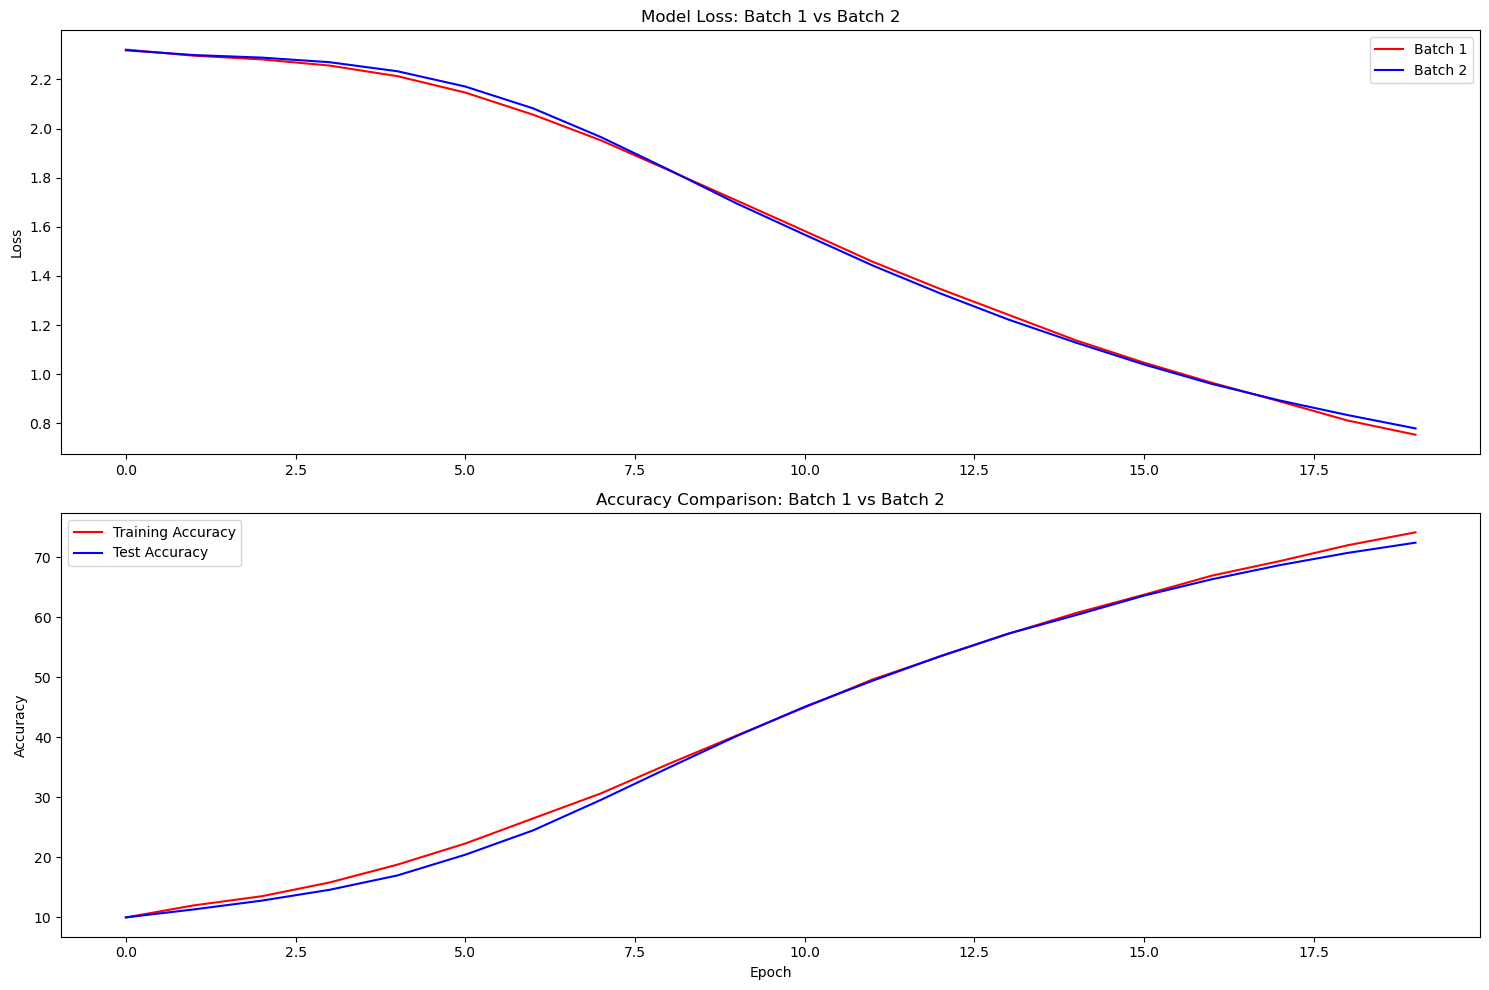

In [13]:
epoch_arr = np.arange(0, 20, 1)

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(epoch_arr, train_losses_batch_1, color="r", label='Batch 1')
plt.plot(epoch_arr, train_losses_batch_2, color="b", label='Batch 2')
plt.title('Model Loss: Batch 1 vs Batch 2')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy comparison
plt.subplot(2, 1, 2)
plt.plot(epoch_arr, train_accuracies_batch_1, color="r", label='Training Accuracy')
plt.plot(epoch_arr, train_accuracies_batch_2, color="b", label='Test Accuracy')
plt.title('Accuracy Comparison: Batch 1 vs Batch 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def compute_metrics_for_loss(model, train_loader, test_loader, loss_func):
    def compute(loader):
        correct = 0
        total = 0
        cost_sum = 0
        cost_counter = 0
        with torch.no_grad():
            for data, target in loader:
                output = model(data)
                cost = loss_func(output, target)
                cost_sum += cost
                cost_counter += 1
                correct += (torch.argmax(output, dim=1) == target).sum().item()
                total += target.size(0)
        return cost_sum / cost_counter, round(correct / total, 3)

    train_loss, train_acc = compute(train_loader)
    test_loss, test_acc = compute(test_loader)
    return train_loss, train_acc, test_loss, test_acc

In [15]:
train_loss_alpha = []
test_loss_alpha = []
train_accuracy_alpha = []
test_accuracy_alpha = []

alpha_values = np.linspace(0, 10, num = 150)
theta_values =[]
theta_values = (1 - alpha_values[:, np.newaxis]) * batch_params_model_1.detach().numpy() + alpha_values[:, np.newaxis] * batch_params_model_2.detach().numpy()

for i in range(len(theta_values)):
    thetac = (1 - alpha_values[i]) * batch_params_model_1 + alpha_values[i] * batch_params_model_2
    model = CNN_Model()  
    torch.nn.utils.vector_to_parameters(thetac, model.parameters())

    temp = [torch.numel(param) for param in model.parameters()]

    train_loss, train_acc, test_loss, test_acc = compute_metrics_for_loss(model, train_loader_1, test_loader_1, loss_func)
    train_loss_alpha.append(train_loss)
    train_accuracy_alpha.append(train_acc)
    test_loss_alpha.append(test_loss)
    test_accuracy_alpha.append(test_acc)

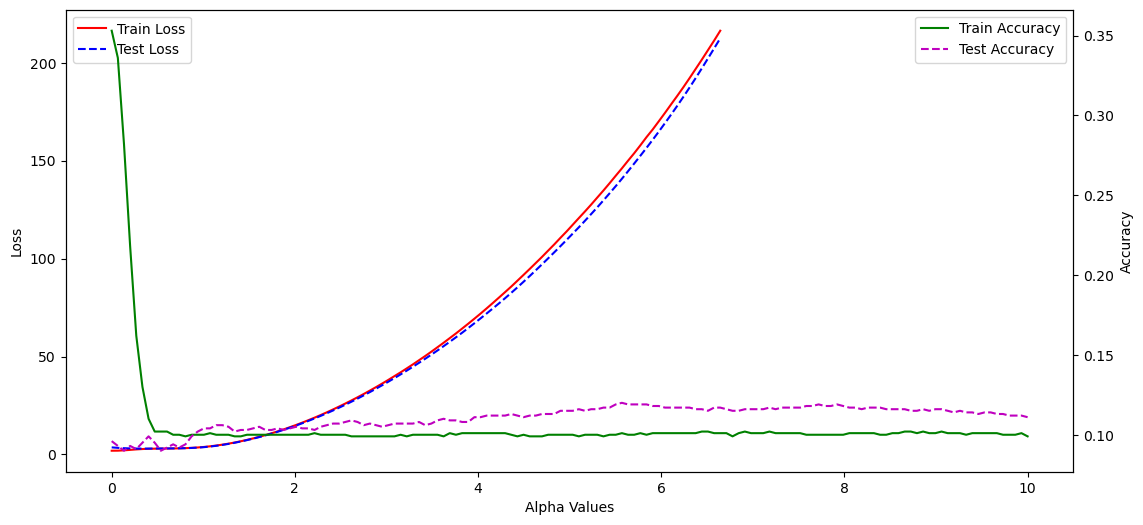

In [23]:
plt.figure(figsize=(13, 6))
plt.plot(alpha_values[:100], train_loss_alpha[:100], color="r", label="Train Loss")
plt.plot(alpha_values[:100], test_loss_alpha[:100], color="b", linestyle='--', label="Test Loss")
plt.xlabel("Alpha Values")
plt.ylabel("Loss", color="black")
plt.tick_params(axis='y', labelcolor="black")
plt.legend(loc="upper left")

plt.twinx()

plt.plot(alpha_values, train_accuracy_alpha, color="g", label="Train Accuracy")
plt.plot(alpha_values, test_accuracy_alpha, color="m", linestyle='--', label="Test Accuracy")
plt.ylabel("Accuracy", color="black")
plt.tick_params(axis='y', labelcolor="black")
plt.legend(loc="upper right")

plt.show()
